<a href="https://colab.research.google.com/github/wuzhouxiang2012/Research/blob/master/HED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import scipy.io as scio
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

In [0]:
import os, sys
import torch
import torch.nn as nn
import torchvision.models as models
import torch.autograd.variable as Variable
import numpy as np
import scipy.io as sio

class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=21)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.score_dsn1 = nn.Conv2d(64, 1, 1)
        self.score_dsn2 = nn.Conv2d(128, 1, 1)
        self.score_dsn3 = nn.Conv2d(256, 1, 1)
        self.score_dsn4 = nn.Conv2d(512, 1, 1)
        self.score_dsn5 = nn.Conv2d(512, 1, 1)
        self.score_final = nn.Conv2d(5, 1, 1)

    def forward(self, x):
        # VGG
        img_H, img_W = x.shape[2], x.shape[3]
        conv1_1 = self.relu(self.conv1_1(x))
        conv1_2 = self.relu(self.conv1_2(conv1_1))
        pool1   = self.maxpool(conv1_2)

        # print('conv1_2 x shape', pool1.shape)

        conv2_1 = self.relu(self.conv2_1(pool1))
        conv2_2 = self.relu(self.conv2_2(conv2_1))
        pool2   = self.maxpool(conv2_2)

        # print('conv2_2 x shape', pool2.shape)

        conv3_1 = self.relu(self.conv3_1(pool2))
        conv3_2 = self.relu(self.conv3_2(conv3_1))
        conv3_3 = self.relu(self.conv3_3(conv3_2))
        pool3   = self.maxpool(conv3_3)

        # print('conv4_3 x shape', pool3.shape)

        conv4_1 = self.relu(self.conv4_1(pool3))
        conv4_2 = self.relu(self.conv4_2(conv4_1))
        conv4_3 = self.relu(self.conv4_3(conv4_2))
        pool4   = self.maxpool(conv4_3)

        # print('conv4_3 x shape', pool4.shape)

        conv5_1 = self.relu(self.conv5_1(pool4))
        conv5_2 = self.relu(self.conv5_2(conv5_1))
        conv5_3 = self.relu(self.conv5_3(conv5_2))

        # print('conv5_3 x shape', conv5_3.shape)

        so1 = self.score_dsn1(conv1_2)
        so2 = self.score_dsn2(conv2_2)
        so3 = self.score_dsn3(conv3_3)
        so4 = self.score_dsn4(conv4_3)
        so5 = self.score_dsn5(conv5_3)
        # print('so1 x shape', so1.shape)
        # print('so2 x shape', so2.shape)
        # print('so3 x shape', so3.shape)
        # print('so4 x shape', so4.shape)
        # print('so5 x shape', so5.shape)

        weight_deconv2 =  make_bilinear_weights(4, 1).cuda()
        # print('weight_deconv2 shape', weight_deconv2.shape)
        weight_deconv3 =  make_bilinear_weights(8, 1).cuda()
        # print('weight_deconv3 shape', weight_deconv3.shape)
        # print(weight_deconv3)
        weight_deconv4 =  make_bilinear_weights(16, 1).cuda()
        # print('weight_deconv4 shape', weight_deconv4.shape)
        # print(weight_deconv4)
        weight_deconv5 =  make_bilinear_weights(32, 1).cuda()
        # print('weight_deconv5 shape', weight_deconv5.shape)
        # print(weight_deconv5)

        upsample2 = torch.nn.functional.conv_transpose2d(so2, weight_deconv2, stride=2)
        upsample3 = torch.nn.functional.conv_transpose2d(so3, weight_deconv3, stride=4)
        upsample4 = torch.nn.functional.conv_transpose2d(so4, weight_deconv4, stride=8)
        upsample5 = torch.nn.functional.conv_transpose2d(so5, weight_deconv5, stride=16)
        # print('upsample2 shape', upsample2.shape)
        # print('upsample3 shape', upsample3.shape)
        # print('upsample4 shape', upsample4.shape)
        # print('upsample5 shape', upsample5.shape)

        so1 = crop(so1, img_H, img_W)
        so2 = crop(upsample2, img_H, img_W)
        so3 = crop(upsample3, img_H, img_W)
        so4 = crop(upsample4, img_H, img_W)
        so5 = crop(upsample5, img_H, img_W)
        # print('After crop')
        # print('so1 x shape', so1.shape)
        # print('so2 x shape', so2.shape)
        # print('so3 x shape', so3.shape)
        # print('so4 x shape', so4.shape)
        # print('so5 x shape', so5.shape)

        fusecat = torch.cat((so1, so2, so3, so4, so5), dim=1)
        # print('fusecat', fusecat.shape)
        fuse = self.score_final(fusecat)
        # print('fuse', fuse.shape)
        results = [so1, so2, so3, so4, so5, fuse]
        results = [torch.sigmoid(r) for r in results]
        return results

def crop(variable, th, tw):
        h, w = variable.shape[2], variable.shape[3]
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return variable[:, :, y1 : y1 + th, x1 : x1 + tw]

# make a bilinear interpolation kernel
def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)

# set parameters s.t. deconvolutional layers compute bilinear interpolation
# N.B. this is for deconvolution without groups
def interp_surgery(in_channels, out_channels, h, w):
    weights = np.zeros([in_channels, out_channels, h, w])
    if in_channels != out_channels:
        raise ValueError("Input Output channel!")
    if h != w:
        raise ValueError("filters need to be square!")
    filt = upsample_filt(h)
    weights[range(in_channels), range(out_channels), :, :] = filt
    return np.float32(weights)

def make_bilinear_weights(size, num_channels):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    # print(filt)
    filt = torch.from_numpy(filt)
    w = torch.zeros(num_channels, num_channels, size, size)
    w.requires_grad = False
    for i in range(num_channels):
        for j in range(num_channels):
            if i == j:
                w[i, j] = filt
    return w

def upsample(input, stride, num_channels=1):
    kernel_size = stride * 2
    kernel = make_bilinear_weights(kernel_size, num_channels).cuda()
    return torch.nn.functional.conv_transpose2d(input, kernel, stride=stride)

In [0]:
net = HED().cuda()

In [0]:
X = torch.rand(1,3,225,225).cuda()
y = net(X)

In [0]:
# initialize params
vgg16 = torchvision.models.vgg16()
net_params = net.state_dict()
vgg_params = vgg16.state_dict()
net_params['conv1_1.bias'] = vgg_params['features.0.bias']
net_params['conv1_1.weight'] = vgg_params['features.0.weight']
net_params['conv1_2.bias'] = vgg_params['features.2.bias']
net_params['conv1_2.weight'] = vgg_params['features.2.weight']
net_params['conv2_1.bias'] = vgg_params['features.5.bias']
net_params['conv2_1.weight'] = vgg_params['features.5.weight']
net_params['conv2_2.bias'] = vgg_params['features.7.bias']
net_params['conv2_2.weight'] = vgg_params['features.7.weight']
net_params['conv3_1.bias'] = vgg_params['features.10.bias']
net_params['conv3_1.weight'] = vgg_params['features.10.weight']
net_params['conv3_2.bias'] = vgg_params['features.12.bias']
net_params['conv3_2.weight'] = vgg_params['features.12.weight']
net_params['conv3_3.bias'] = vgg_params['features.14.bias']
net_params['conv3_3.weight'] = vgg_params['features.14.weight']
net_params['conv4_1.bias'] = vgg_params['features.17.bias']
net_params['conv4_1.weight'] = vgg_params['features.17.weight']
net_params['conv4_2.bias'] = vgg_params['features.19.bias']
net_params['conv4_2.weight'] = vgg_params['features.19.weight']
net_params['conv4_3.bias'] = vgg_params['features.21.bias']
net_params['conv4_3.weight'] = vgg_params['features.21.weight']
net_params['conv5_1.bias'] = vgg_params['features.24.bias']
net_params['conv5_1.weight'] = vgg_params['features.24.weight']
net_params['conv5_1.weight'] = vgg_params['features.24.weight']
net_params['conv5_2.bias'] = vgg_params['features.26.bias']
net_params['conv5_2.weight'] = vgg_params['features.26.weight']
net_params['conv5_3.bias'] = vgg_params['features.28.bias']
net_params['conv5_3.weight'] = vgg_params['features.28.weight']

net.load_state_dict(net_params)


<All keys matched successfully>

In [0]:
import os
path = '/content/drive/My Drive/colab/BSDS500/data/images/test'
test_list=[]
for fpath, dirname, fnames in os.walk(path):
    for fname in fnames:
      if 'jpg' in fname:
        test_list.append(os.path.join(fpath, fname))
np.save('/content/drive/My Drive/colab/BSDS500/test_images_list.npy', test_list)
path = '/content/drive/My Drive/colab/BSDS500/data/images/train'
train_list=[]
for fpath, dirname, fnames in os.walk(path):
    for fname in fnames:
      if 'jpg' in fname:
        train_list.append(os.path.join(fpath, fname))
path = '/content/drive/My Drive/colab/BSDS500/data/images/val'
for fpath, dirname, fnames in os.walk(path):
    for fname in fnames:
      if 'jpg' in fname:
        train_list.append(os.path.join(fpath, fname))
np.save('/content/drive/My Drive/colab/BSDS500/train_images_list.npy', train_list)

In [0]:
groundTruth_path = '/content/drive/My Drive/colab/BSDS500/data/groundTruth/'
train_labels_list = [groundTruth_path+x.split('/')[-2]+'/'+x.split('/')[-1].split('.')[0]+\
                     '.mat' for x in train_list]
test_labels_list = [groundTruth_path+x.split('/')[-2]+'/'+x.split('/')[-1].split('.')[0]+\
                     '.mat' for x in test_list]
np.save('/content/drive/My Drive/colab/BSDS500/train_labels_list.npy', train_labels_list)
np.save('/content/drive/My Drive/colab/BSDS500/test_labels_list.npy', test_labels_list)

In [0]:
class BSDSData(Dataset):
    def __init__(self, train_file, label_file):
        #定义好 image 的路径
        self.images = np.load(train_file).tolist()
        self.labels = np.load(label_file).tolist()

    def __getitem__(self, index):
        image_path = self.images[index]
        image = self.load_image(image_path)
        label_path = self.labels[index]
        label = torch.tensor(self.load_label(label_path))
        # print(image.shape, label.shape)
        # print(type(image), type(label))
        return image,label

    def __len__(self):
        return len(self.images)
    
    def load_image(self, path):
      img_pil =  Image.open(path)
      normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
      )
      preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
      ])
      img_tensor = preprocess(img_pil)
      return img_tensor

    def load_label(self, path):
      return scio.loadmat(path)['groundTruth'][0][0][0][0][1]

In [0]:
train_images_list_path = '/content/drive/My Drive/colab/BSDS500/train_images_list.npy'
train_labels_list_path = '/content/drive/My Drive/colab/BSDS500/train_labels_list.npy'
test_images_list_path = '/content/drive/My Drive/colab/BSDS500/test_images_list.npy'
test_labels_list_path = '/content/drive/My Drive/colab/BSDS500/test_labels_list.npy'

In [0]:
def evaluate_loss(test_iter, net, loss, device):
  cnt = 0
  sum_loss = 0.0
  net.to(device)
  for X, y in test_iter:
      X = X.to(device)
      y = y.to(device)
      outputs = net(X)
      loss = torch.zeros(1).cuda()
      for o in outputs:
        loss = loss + cross_entropy_loss(o, y)
      sum_loss += loss.item()
      cnt += X.shape[0]
  return sum_loss/cnt

In [0]:
def cross_entropy_loss(prediction, label):
    label = label.long()
    
    mask = (label != 0).float()
    num_positive = torch.sum(mask).float()
    num_negative = mask.numel() - num_positive
    #print (num_positive, num_negative)
    mask[mask != 0] = num_negative / (num_positive + num_negative)
    mask[mask == 0] = num_positive / (num_positive + num_negative)
    # print('prediction type', type(prediction))
    # print('label type', type(label))
    cost = torch.nn.functional.binary_cross_entropy(prediction.float(),label.float(), weight=mask, reduce=False)
    return torch.sum(cost)

In [0]:
lr = 0.001
num_epochs = 100
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = cross_entropy_loss
batch_size = 1
train_dataset = BSDSData(train_images_list_path, train_labels_list_path)
test_dataset = BSDSData(test_images_list_path, test_labels_list_path)
train_iter = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [0]:
for epoch in range(num_epochs):
  train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
  for X, y in train_iter:
    X = X.to(device)
    y = y.to(device)
    outputs = net(X)
    loss = torch.zeros(1).cuda()
    for o in outputs:
      loss = loss + cross_entropy_loss(o, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_l_sum += loss.cpu().item()
    n += y.shape[0]
    batch_count += 1
  test_loss = evaluate_loss(test_iter, net, loss, device)
  print('epoch %d, train loss %.3f, test loss %.3f, time %.1f sec' %
    (epoch + 1, train_l_sum / batch_count, test_loss, time.time() - start))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Using a target size (torch.Size([1, 321, 481])) that is different to the input size (torch.Size([1, 1, 321, 481])) is deprecated. Please ensure they have the same size.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Using a target size (torch.Size([1, 481, 321])) that is different to the input size (torch.Size([1, 1, 481, 321])) is deprecated. Please ensure they have the same size.
  if sys.path[0] == '':


epoch 1, train loss 17106.110, test loss 18261.006, time 28.2 sec
epoch 2, train loss 16238.262, test loss 18440.735, time 28.1 sec
epoch 3, train loss 16083.539, test loss 17767.297, time 28.4 sec
epoch 4, train loss 15988.294, test loss 17628.414, time 28.2 sec
epoch 5, train loss 15752.392, test loss 17444.582, time 28.2 sec
epoch 6, train loss 15672.344, test loss 20612.644, time 28.2 sec
epoch 7, train loss 15480.418, test loss 17592.000, time 28.2 sec
epoch 8, train loss 15246.652, test loss 16977.437, time 28.2 sec
epoch 9, train loss 15101.522, test loss 16951.041, time 28.1 sec
epoch 10, train loss 15109.274, test loss 16938.769, time 28.4 sec
epoch 11, train loss 15525.285, test loss 17143.323, time 28.7 sec
epoch 12, train loss 14888.184, test loss 16879.220, time 28.5 sec
epoch 13, train loss 14935.047, test loss 16751.512, time 28.6 sec
epoch 14, train loss 14848.792, test loss 16808.099, time 28.8 sec
epoch 15, train loss 14619.491, test loss 17065.787, time 28.7 sec
epoc

KeyboardInterrupt: ignored

In [0]:
def evaluate(image_path, net):
  net.eval()
  image = Image.open(image_path)
  images = []
  normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )
  preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
  ])
  X = preprocess(image).unsqueeze_(0).cuda()
  outputs = net(X)
  for o in outputs:
    o[o>0.5]=1
    o[o<0.5]=0
    o *= 255
    o.squeeze_()
    o.detach_()
    o = o.to('cpu')
    o = o.numpy().astype(np.uint8)
    # print(o.shape)
    # print(o.dtype)
    # print(o)
    images.append(o)
  print(len(images))
  plt.figure()

  #subplot(r,c) provide the no. of rows and columns
  f, axarr = plt.subplots(len(images)+1,1, figsize=(30,30)) 
  # use the created array to output your multiple images. In this case I have stacked 4 images vertically
  axarr[0].imshow(image)
  for i in range(len(images)):
    axarr[i+1].imshow(Image.fromarray(images[i], 'L'))
  plt.show()

6


<Figure size 432x288 with 0 Axes>

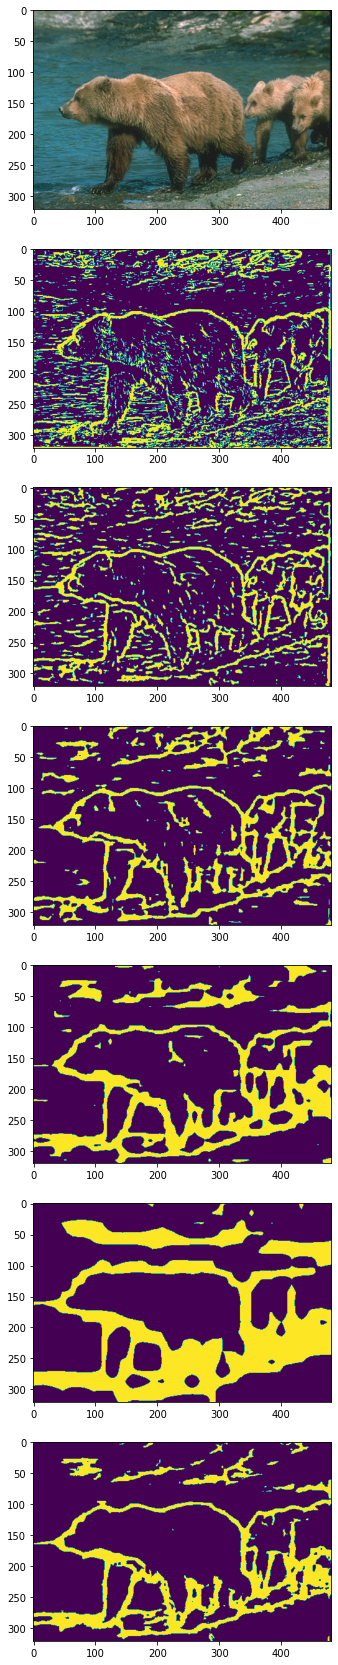

In [0]:
image_path = '/content/drive/My Drive/colab/BSDS500/data/images/train/100075.jpg'
evaluate(image_path, net)

In [0]:
image_path = '/content/drive/My Drive/test_photos/女生.JPG'
evaluate(image_path, net)
# torch.save(net.state_dict(), '/content/drive/My Drive/colab/my_model.pth')

RuntimeError: ignored

In [0]:

net_author = torch.load('/content/drive/My Drive/colab/my_model.pth')

FileNotFoundError: ignored

6


<Figure size 432x288 with 0 Axes>

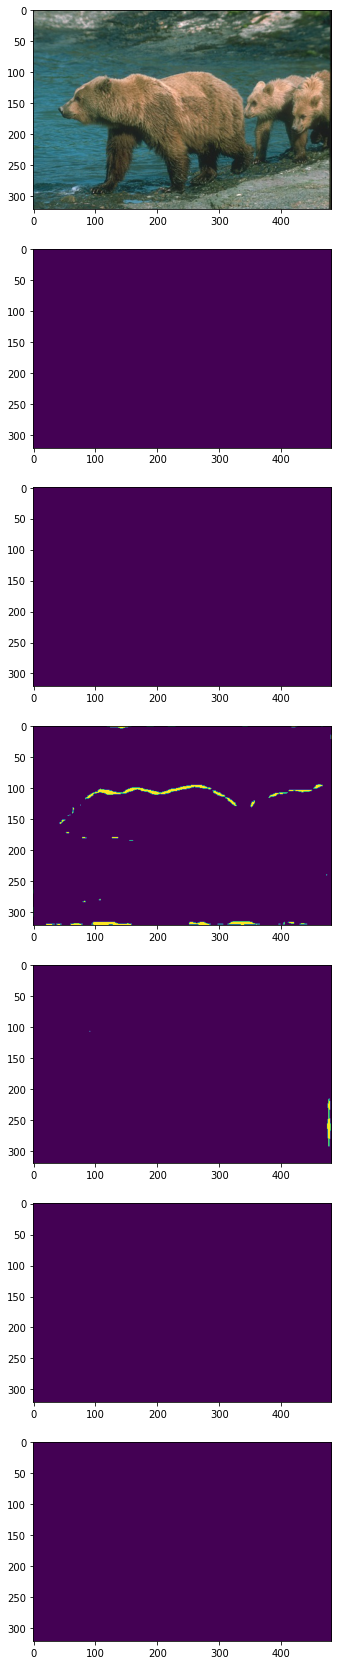

In [0]:
model = HED()
model.load_state_dict(net_author['state_dict'])
model.eval()
model = model.cuda()

evaluate(image_path, model)

In [0]:
net_author=torch.load('/content/drive/My Drive/colab/Hedcheckpoint_epoch9.pth')
net_author['state_dict']['score_final.weight'] = net_author['state_dict']['new_score_weighting.weight']
net_author['state_dict']['score_final.bias'] = net_author['state_dict']['new_score_weighting.bias']
del net_author['state_dict']['new_score_weighting.weight']
del net_author['state_dict']['new_score_weighting.bias']

In [0]:
b = X['groundTruth'][0][2][0][0][1]*255
c = X['groundTruth'][0][3][0][0][1]*255
d = X['groundTruth'][0][4][0][0][1]*255
e = X['groundTruth'][0][5][0][0][1]*255
f = X['groundTruth'][0][0][0][0][1]*255

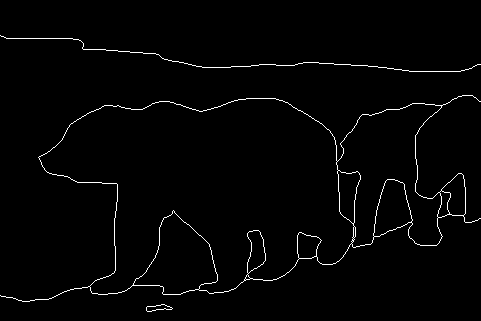

In [0]:
Image.fromarray(b)

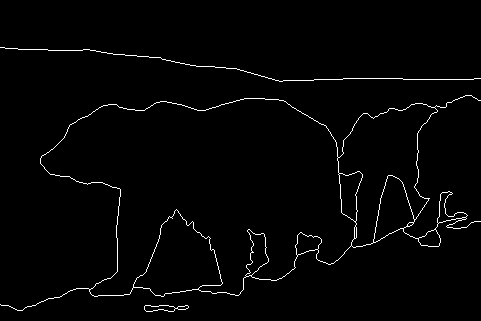

In [0]:
Image.fromarray(c)